In [2]:
from __future__ import annotations
import os
import sys
import numpy as np
sys.path.append('/home/gpuvmadm/PyTomography/src')
import pytomography
from pytomography.metadata import SPECTObjectMeta, SPECTProjMeta
from pytomography.projectors import SPECTSystemMatrix
from pytomography.algorithms import OSEMOSL
from pytomography.priors import RelativeDifferencePrior
from pytomography.transforms import PETAttenuationTransform, PETPSFTransform
import matplotlib.pyplot as plt
import matplotlib
matplotlib.rcParams['mathtext.fontset'] = 'stix'
matplotlib.rcParams['font.family'] = 'STIXGeneral'
import torch
from scipy.ndimage import zoom
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
pytomography.device = device
import matplotlib

Change this to where you saved the data

In [3]:
datapath = '/disk1/pytomography_paper_data'

Data obtained from XCAT phantom

In [4]:
GTo = np.fromfile(os.path.join(datapath, 'pet', 'body2_F18_temp.bin'), dtype=np.float32)
CTo = np.fromfile(os.path.join(datapath, 'pet', 'body_atn_511keV_full.bin'), dtype=np.float32)

Reshape and resize ground truth

In [5]:
GTo = GTo.reshape((768,512,512))
CTo = CTo.reshape((768,512,512))
GT = zoom(GTo, (384/768, 256/512, 256/512), order=1)
CT = zoom(CTo, (384/768, 256/512, 256/512), order=1)
GT = np.transpose(GT, (2,1,0))
CT = np.transpose(CT, (2,1,0))
GT = torch.tensor(GT).unsqueeze(dim=0)
CT = torch.tensor(CT).unsqueeze(dim=0)

Define metadata (we use SPECT b/c this suffices for PET2D meta)

In [6]:
object_meta = SPECTObjectMeta(dr=(0.15,0.15,0.767), shape=[256,256,384])
proj_meta = SPECTProjMeta(angles=np.linspace(0,180,300, endpoint=False), radii=20.0*np.ones(300), projection_shape=(256,384))

In [7]:
dx, dy, dz = object_meta.dr
dt = 10 #seconds
scale_factor = dx*dy*dz * 176 / proj_meta.num_projections * dt  #176 cps / Bq in Siemen scanner

In [8]:
def kernel_noncol(x,r,R, delta=1e-8):
    if r**2<R**2:
        sigma = torch.sqrt(R**2 - r**2)/4 * np.pi / 180
    else:
        sigma = torch.zeros(r.shape) + delta
    result = torch.exp(-x**2/sigma**2 / 2)
    return result / (torch.sum(result)+delta)

def kernel_penetration(x,r,R,mu=0.87, delta=1e-8):
    result = torch.exp(-torch.abs(mu*x / ((r/R)*torch.sqrt(1-(r/R)**2) + delta)))
    if r>=0:
        result*= x <= 0
    else:
        result*= x >= 0
    return result / (torch.sum(result)+delta)

def kernel_scattering(x,r,R,scatter_fact=0.327, delta=1e-8):
    sigma = scatter_fact * torch.sqrt(1-(r/R)**2) / (2 * np.sqrt(2*np.log(2))) # fwhm -> sigma
    result = torch.exp(-x**2/sigma**2 / 2)
    return result / (torch.sum(result)+delta)

In [9]:
kernels = [kernel_noncol, kernel_penetration, lambda x, r, R: kernel_penetration(2*x, r, R), kernel_scattering]

In [10]:
attenuation_transform = PETAttenuationTransform(CT = CT)
psf_transform = PETPSFTransform(kernels)
H = SPECTSystemMatrix(
    obj2obj_transforms=[],
    proj2proj_transforms=[attenuation_transform, psf_transform],
    object_meta=object_meta,
    proj_meta=proj_meta,
    n_parallel=2)

/data/anaconda/envs/pytomographytest/lib/python3.9/site-packages/torch/functional.py:478: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at  ../aten/src/ATen/native/TensorShape.cpp:2894.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


In [12]:
m = np.zeros((25, 256))
for i in range(0, 256):
    j = i+54
    m[:,i] = psf_transform.PSF_matrix[0,0,0,j,j-12:j+13].cpu()
x = np.arange(-12,13)*object_meta.dx
y = np.arange(-128,128)*object_meta.dx

What the kernel looks like:

/tmp/ipykernel_8868/3290128969.py:6: MatplotlibDeprecationWarning: Unable to determine Axes to steal space for Colorbar. Using gca(), but will raise in the future. Either provide the *cax* argument to use as the Axes for the Colorbar, provide the *ax* argument to steal space from it, or add *mappable* to an Axes.
  fig.colorbar(sm, ticks=cs.levels)


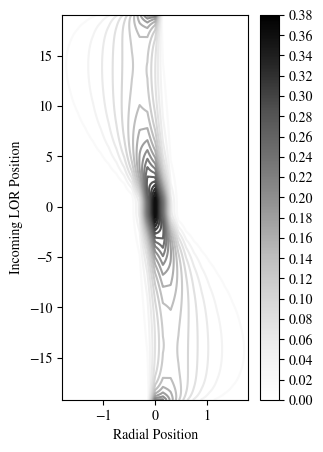

In [13]:
fig = plt.figure(figsize=(3,5))
cs = plt.contour(x, y, m.T+1e-9, cmap='Greys', levels=21)
norm= matplotlib.colors.Normalize(vmin=cs.cvalues.min(), vmax=cs.cvalues.max())
sm = plt.cm.ScalarMappable(norm=norm, cmap = cs.cmap)
sm.set_array([])
fig.colorbar(sm, ticks=cs.levels)
plt.ylabel('Incoming LOR Position')
plt.xlabel('Radial Position')
plt.show()

# Noise Free

In [14]:
projections_analytic = H.forward(GT*scale_factor)

Make a reconstruction network

In [16]:
osem_net = OSEMOSL(projections = projections_analytic,
                   system_matrix = H)
reconstructed_object = osem_net(n_iters=10, n_subsets=14) 

Try reconstructing without PSF

In [17]:
H_bad = SPECTSystemMatrix(
    obj2obj_transforms=[],
    proj2proj_transforms=[attenuation_transform],
    object_meta=object_meta,
    proj_meta=proj_meta)
osem_net_bad = OSEMOSL(projections = projections_analytic,
                   system_matrix = H_bad)
reconstructed_object_bad = osem_net_bad(n_iters=10, n_subsets=14)

Plot

In [18]:
xmin = 59
xmax = 89
zmin = 116
zmax = 131
z = 124
xmin = 59
xmax = 89
ymin = 108
ymax = 138
xloc = 148 / 2
yloc = 248 / 2
z_profile = 200
reference = np.transpose(GTo, (2,1,0))
def plot_object(obj, ax, mode, y=None):
    if mode=='color':
        tcol = 'white'
        cmap = 'nipy_spectral'
        vmax = 31
        ls = '-'
    elif mode=='bw':
        tcol = 'red'
        cmap = 'Greys'
        vmax = 10
        ls = '--'
    plt.sca(ax)
    if y is None:
        im = plt.pcolormesh(obj[0].max(axis=1)[0].cpu().T, cmap=cmap, vmax=vmax)
    else:
        im = plt.pcolormesh(obj[0][:,y].cpu().T, cmap=cmap, vmax=vmax)
    plt.plot([xmin,xmax,xmax,xmin,xmin],[zmin,zmin,zmax,zmax,zmin], color=tcol, ls=ls)
    plt.text(xmin,zmin-10,'Lesion', color=tcol)
    ax.tick_params(axis='both', which='both', length=0)
    ax.set_xticklabels([])
    ax.set_yticklabels([])
    return im
    
def plot_axial(ob, ax, z, xmin, xmax, ymin, ymax, xloc, yloc, mode):
    if mode=='color':
        tcol = 'white'
        cmap = 'nipy_spectral'
    elif mode=='bw':
        tcol = 'red'
        cmap = 'Greys'
    plt.sca(ax)
    im = plt.pcolormesh(ob[:,:,z].T, cmap=cmap, vmax=110)
    plt.xlim(xmin,xmax)
    plt.ylim(ymin,ymax)
    plt.axvline(xloc, color=tcol, ls='--', lw=0.6)
    plt.axhline(yloc, color=tcol, ls='--', lw=0.6)
    ax.tick_params(axis='both', which='both', length=0)
    ax.set_xticklabels([])
    ax.set_yticklabels([])
    return im

def plot_slice(ob, ax, z, y, color, label):
    plt.sca(ax)
    plt.plot(ob[:,y,z].T, color=color, label=label)

/tmp/ipykernel_8868/2183322394.py:27: MatplotlibDeprecationWarning: Unable to determine Axes to steal space for Colorbar. Using gca(), but will raise in the future. Either provide the *cax* argument to use as the Axes for the Colorbar, provide the *ax* argument to steal space from it, or add *mappable* to an Axes.
  fig.colorbar(sm, ticks=cs.levels[::3])


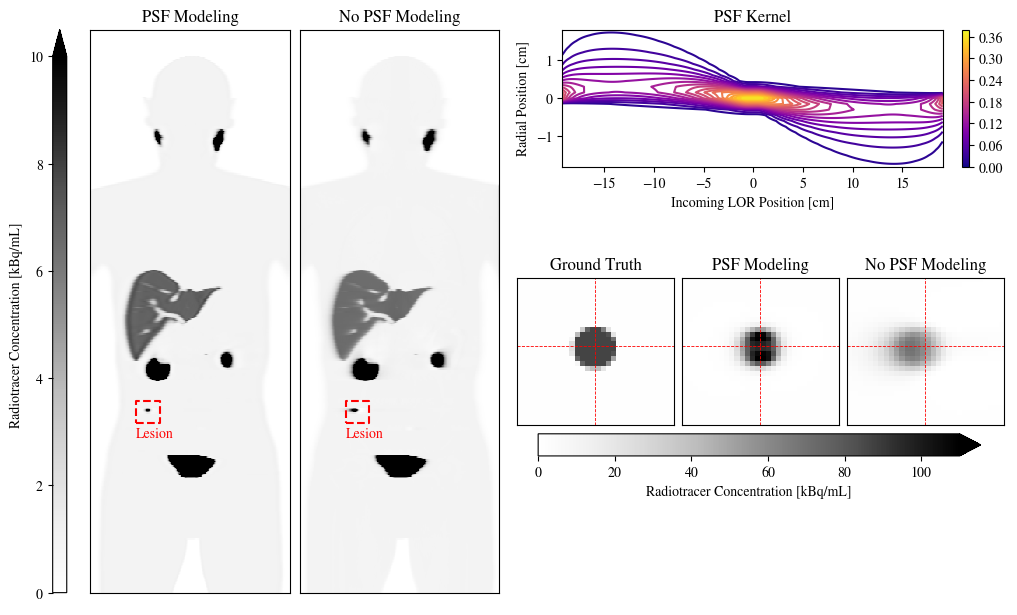

In [22]:
mode = 'bw'
fig = plt.figure(constrained_layout=True, figsize=(10,6))
(subfig_l, subfig_r) = fig.subfigures(nrows=1, ncols=2, width_ratios=(1,1))
axes_l = subfig_l.subplots(nrows=1, ncols=2)
axes_l[0].set_title('PSF Modeling')
axes_l[1].set_title('No PSF Modeling')
im = plot_object(reconstructed_object / scale_factor, axes_l[0], mode=mode, y=128)
im = plot_object(reconstructed_object_bad / scale_factor, axes_l[1], mode=mode, y=128)
subfig_l.colorbar(im, ax=axes_l, location='left', label='Radiotracer Concentration [kBq/mL]', extend='max', aspect=40
                  )
(subfig_r_l, subfig_r_u, _) = subfig_r.subfigures(nrows=3, ncols=1, hspace=0.2, height_ratios=[1,1.2,0.3])
axes_r_u = subfig_r_u.subplots(nrows=1, ncols=3)
#plot_axial(reference, axes_r_u[0], int(z*(751/384)), 2*xmin, 2*xmax, 2*ymin, 2*ymax, 2*xloc, 2*yloc)
im = plot_axial(GT[0].cpu(), axes_r_u[0], z, xmin, xmax, ymin, ymax, xloc, yloc, mode)
axes_r_u[0].set_title('Ground Truth')
im = plot_axial(reconstructed_object[0].cpu() / scale_factor, axes_r_u[1], z, xmin, xmax, ymin, ymax, xloc, yloc, mode)
axes_r_u[1].set_title('PSF Modeling')
im = plot_axial(reconstructed_object_bad[0].cpu() / scale_factor, axes_r_u[2], z, xmin, xmax, ymin, ymax, xloc, yloc, mode)
axes_r_u[2].set_title('No PSF Modeling')
subfig_r_u.colorbar(im, ax=axes_r_u, location='bottom', label='Radiotracer Concentration [kBq/mL]', extend='max')
axes_r_l = subfig_r_l.subplots(nrows=1, ncols=1)
plt.sca(axes_r_l)
cs = plt.contour(y, x, m+1e-9, cmap='plasma', levels=21)
norm= matplotlib.colors.Normalize(vmin=cs.cvalues.min(), vmax=cs.cvalues.max())
sm = plt.cm.ScalarMappable(norm=norm, cmap = cs.cmap)
sm.set_array([])
fig.colorbar(sm, ticks=cs.levels[::3])
plt.xlabel('Incoming LOR Position [cm]')
plt.ylabel('Radial Position [cm]')
plt.title('PSF Kernel')
plt.savefig('images/figure7.jpg', bbox_inches='tight', dpi=300)